# **Categorizing Movie Reviews**

*<b>BERT MODEL ATTEMPTED</b>*

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## **Import Packages**

In [99]:
# Import packages
import math
import re
from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords

import spacy
from spacy.lang.en import stop_words as spacy_stopwords

from lightgbm import LGBMClassifier

import torch
import transformers

In [51]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

/var/folders/q7/2k38l43j455fh7f8t9_wlj240000gn/T/ipykernel_14180/1225062909.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [52]:
# Set style
sns.set_theme(style="whitegrid")

## **Load Data**

In [53]:
# Import data
df_reviews = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/imdb_reviews.tsv', 
                      sep = '\t', parse_dates=True)

In [54]:
# Data info
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

In [55]:
# Data head
display(df_reviews.sample(15))

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
41254,tt0821375,tvSeries,The Sarah Silverman Program.,The Sarah Silverman Program.,2007,2010,22,0,Comedy,6.8,7095.0,I remember my parents not understanding Saturd...,1,neg,0,train,3496
10424,tt0072895,movie,Dolemite,Dolemite,1975,\N,90,0,"Action,Comedy,Crime",5.8,5063.0,"I love the so-called ""blaxploitation"" films an...",1,neg,0,test,482
39457,tt0049470,movie,The Man Who Knew Too Much,The Man Who Knew Too Much,1956,\N,120,0,"Drama,Thriller",7.5,55994.0,1956's The Man Who Knew Too Much is exceptiona...,10,pos,1,test,10148
38122,tt0872204,short,The Idea,The Idea,2006,\N,10,0,Short,8.4,19.0,I saw this film with a special screening of th...,10,pos,1,train,9118
21575,tt0074855,movie,Mandinga,Mandinga,1976,\N,86,0,"Adventure,Drama",3.3,153.0,Obviously made on the cheap to capitalize on t...,8,pos,1,test,3620
12058,tt0765447,movie,Evening,Evening,2007,\N,117,0,"Drama,Romance",6.5,12842.0,"Almost as tedious to watch as it was to read, ...",2,neg,0,train,526
33471,tt0098924,tvSeries,TaleSpin,TaleSpin,1990,1991,30,0,"Action,Adventure,Animation",7.6,12977.0,"Ever since I remember, I have loved airplanes ...",10,pos,1,train,11992
46984,tt0066601,movie,Zabriskie Point,Zabriskie Point,1970,\N,113,0,Drama,7.0,14171.0,When I saw the film for the first time in the ...,7,pos,1,train,6008
9153,tt0065611,movie,Darling Lili,Darling Lili,1970,\N,136,0,"Comedy,Drama,Musical",6.1,1911.0,This Blake Edwards film isn't too sure whether...,10,pos,1,test,67
47307,tt0972534,tvSeries,iCarly,iCarly,2007,2012,30,0,"Comedy,Family,Romance",6.6,31143.0,"Miranda Cosgrove is known for her debut in ""Sc...",3,neg,0,test,5653


### Initial data observations

The dataset contains 47331 observations and 16 columns representing movie df_df_df_reviews and their classification, positive or negative. Runtime_minutes needs to be converted to int64. There are no missing values.

## **Prepare Data**

### Fix data types

In [56]:
# Check values of runtime
display(sorted(df_reviews['runtime_minutes'].unique()))

['1',
 '10',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '11',
 '110',
 '111',
 '112',
 '113',
 '114',
 '1140',
 '115',
 '116',
 '117',
 '118',
 '119',
 '12',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '13',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '14',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '15',
 '150',
 '151',
 '152',
 '153',
 '154',
 '155',
 '156',
 '157',
 '159',
 '16',
 '160',
 '161',
 '162',
 '163',
 '164',
 '165',
 '166',
 '167',
 '168',
 '169',
 '17',
 '170',
 '171',
 '172',
 '173',
 '174',
 '175',
 '176',
 '177',
 '178',
 '179',
 '18',
 '180',
 '181',
 '183',
 '185',
 '186',
 '188',
 '189',
 '19',
 '190',
 '192',
 '194',
 '197',
 '199',
 '2',
 '20',
 '200',
 '201',
 '202',
 '204',
 '208',
 '21',
 '210',
 '211',
 '212',
 '215',
 '216',
 '217',
 '219',
 '22',
 '222',
 '225',
 '229',
 '23',
 '230',
 '232',
 '233',
 '239',
 

Missing values for runtime were entered as '\\N', which is causing the data to be mis-typed as object. Changing '\\N' to np.nan will allow the variable to be converted to to float64.

In [57]:
# Replace '\\N' with np.nan
df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].replace('\\N', np.nan)

# Convert runtime to int64
df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].astype('float')

# Display info
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  46843 non-null  float64
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(3

Runtime_minutes is converted to float.

### Check for duplicates

In [58]:
# Check for full duplicates
duplicates_count = df_reviews.duplicated().sum()

print(f'Number of full duplicates: {duplicates_count}')

Number of full duplicates: 0


There are no fully duplicate rows.

In [59]:
# Check for review duplicates
review_duplicates = df_reviews['review'].duplicated().sum()

print(f'Number of duplicated review texts: {review_duplicates}')

Number of duplicated review texts: 91


There are 91 duplicated df_reviews. Print rows to further inspect the duplication.

In [60]:
# Print duplicated rows
duplicate_review_text = df_reviews['review'].duplicated(keep=False)

display(df_reviews[duplicate_review_text])

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
1368,tt0081949,tvMiniSeries,A Town Like Alice,A Town Like Alice,1981,1981,301.0,0,"Drama,Romance,War",8.3,849.0,I have seen this film at least 100 times and I...,10,pos,1,test,9765
1370,tt0081949,tvMiniSeries,A Town Like Alice,A Town Like Alice,1981,1981,301.0,0,"Drama,Romance,War",8.3,849.0,I have seen this film at least 100 times and I...,10,pos,1,test,9768
1629,tt0098994,movie,"After Dark, My Sweet","After Dark, My Sweet",1990,\N,114.0,0,"Crime,Drama,Mystery",6.6,3098.0,THE JIST: See something else. This film was hi...,7,pos,1,train,7728
1630,tt0098994,movie,"After Dark, My Sweet","After Dark, My Sweet",1990,\N,114.0,0,"Crime,Drama,Mystery",6.6,3098.0,THE JIST: See something else. This film was hi...,7,pos,1,train,7729
1753,tt0086662,tvSeries,Airwolf,Airwolf,1984,1986,60.0,0,"Action,Adventure,Sci-Fi",6.7,9592.0,I used to watch this show when I was a little ...,9,pos,1,train,6769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47175,tt0463392,movie,Zombie Nation,Zombie Nation,2004,\N,81.0,0,Horror,2.0,7850.0,German filmmaker Ulli Lommel has managed a tas...,1,neg,0,train,10089
47194,tt0463392,movie,Zombie Nation,Zombie Nation,2004,\N,81.0,0,Horror,2.0,7850.0,German filmmaker Ulli Lommel has managed a tas...,1,neg,0,train,10108
47288,tt0972534,tvSeries,iCarly,iCarly,2007,2012,30.0,0,"Comedy,Family,Romance",6.6,31143.0,Nickelodeon has gone down the toilet. They hav...,1,neg,0,test,5652
47290,tt0972534,tvSeries,iCarly,iCarly,2007,2012,30.0,0,"Comedy,Family,Romance",6.6,31143.0,Nickelodeon has gone down the toilet. They hav...,1,neg,0,test,5655


The rows are fully duplicated other than the idx index variable. Duplicates will be dropped from the dataset.

In [61]:
# Drop duplicates
reivews = df_reviews.drop_duplicates(subset=['review'], inplace=True)

duplicates_new = df_reviews['review'].duplicated().sum()

print(f'Updated number of duplicates: {duplicates_new}')

Updated number of duplicates: 0


Duplicates have been removed from the dataset.

## Missing values

In [62]:
# Replace all '\N' with np.nan
df_reviews = df_reviews.replace('\\N', np.nan)

In [63]:
# Calculate number and percent of missing values by columns
missing = df_reviews.isna().sum().reset_index().rename(columns=
                                                       {'index':'column',
                                                        0:'count'})

missing['percent'] = ((missing['count'] / len(df_reviews)) * 100).round(2)

print('Missing Values:')
display(missing)

Missing Values:


,column,count,percent
0,tconst,0,0.00
1,title_type,0,0.00
2,primary_title,0,0.00
3,original_title,0,0.00
4,start_year,0,0.00
5,end_year,44967,95.19
6,runtime_minutes,488,1.03
7,is_adult,0,0.00
8,genres,26,0.06
9,average_rating,2,0.00


End_year is missing over 95% of values, runtime_minutes is missing 1% of valeus, and genres, average_rating, and votes are all missing less than 1% of values. Because of the high number missing in end_year, this variable will be dropped from the analysis. The number missing in other variables is so low that imputation isn't necessary. The rows missing information will be dropped from the dataset.

In [64]:
# Drop rows missing values in runtime, genre, rating, or votes
df_reviews = df_reviews.dropna(subset=['runtime_minutes', 'genres', 'average_rating', 'votes'])

missing_dropped = df_reviews.isna().sum().reset_index().rename(columns=
                                                       {'index':'column',
                                                        0:'count'})

missing_dropped['percent'] = ((missing_dropped['count'] / len(df_reviews)) * 100).round(2)

print('Missing values after dropping missing rows:')
display(missing_dropped)

Missing values after dropping missing rows:


,column,count,percent
0,tconst,0,0.0
1,title_type,0,0.0
2,primary_title,0,0.0
3,original_title,0,0.0
4,start_year,0,0.0
5,end_year,44586,95.4
6,runtime_minutes,0,0.0
7,is_adult,0,0.0
8,genres,0,0.0
9,average_rating,0,0.0


There are no more missing values, after dropping rows missing in the runtime, genre, rating, and votes subest. End_year will be left out of analyses.

### Prepare data conclusion

Duplicates and missing values have been dropped from the dataset. The data is ready for analysis.

## **Exploratory data analysis**

### Number of unique titles

In [65]:
# Find number of movies reviewed in the dataset
movie_count = df_reviews['primary_title'].nunique()

print(f'Number of unique movie titles: {movie_count}')

Number of unique movie titles: 6420


### Reviews by media type

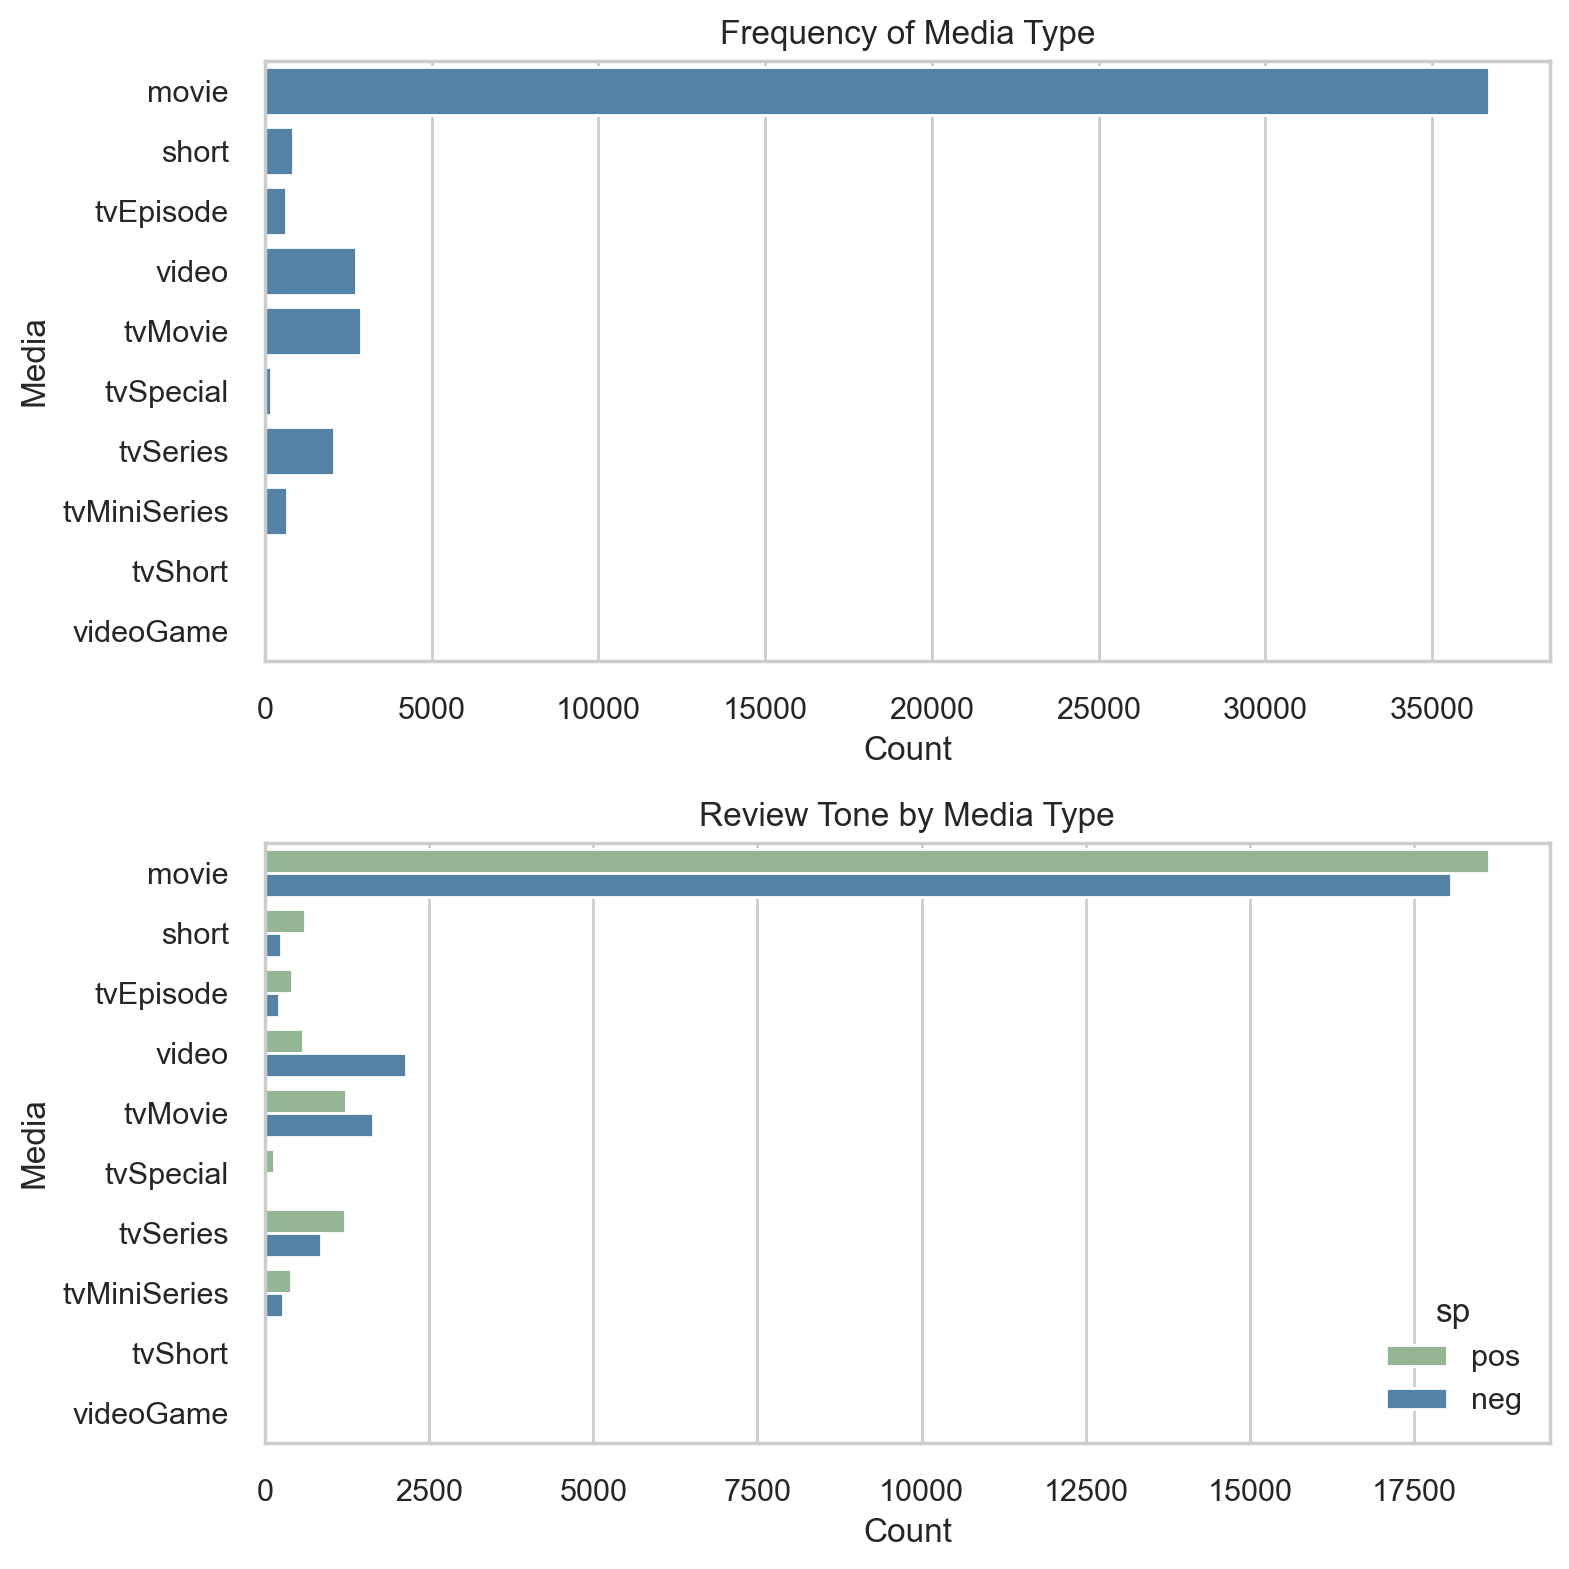

In [66]:
# Graph number of movies and review tone by media type
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Media frequency plot
type_count = sns.countplot(ax=axs[0], data=df_reviews, y='title_type', color='steelblue')
type_count.set(title='Frequency of Media Type', xlabel='Count', ylabel='Media')

# Review tone by media plot
type_review = sns.countplot(ax=axs[1], data=df_reviews, y='title_type', hue='sp', 
                            hue_order=['pos', 'neg'], palette=('darkseagreen', 'steelblue'))
type_review.set(title='Review Tone by Media Type', xlabel='Count', ylabel='Media')

# Show plots
fig.tight_layout()
plt.show()

Most reviews are for movies. There are only a small number of reviews for other media types such as shorts, tv episodes, videos, tv movies, etc. Movies, shorts, tv episodes, and tv series tend to have more positive than negative reviews. Videos and tvmovies have more negative than positive reviews.

### Movies and reviews by year

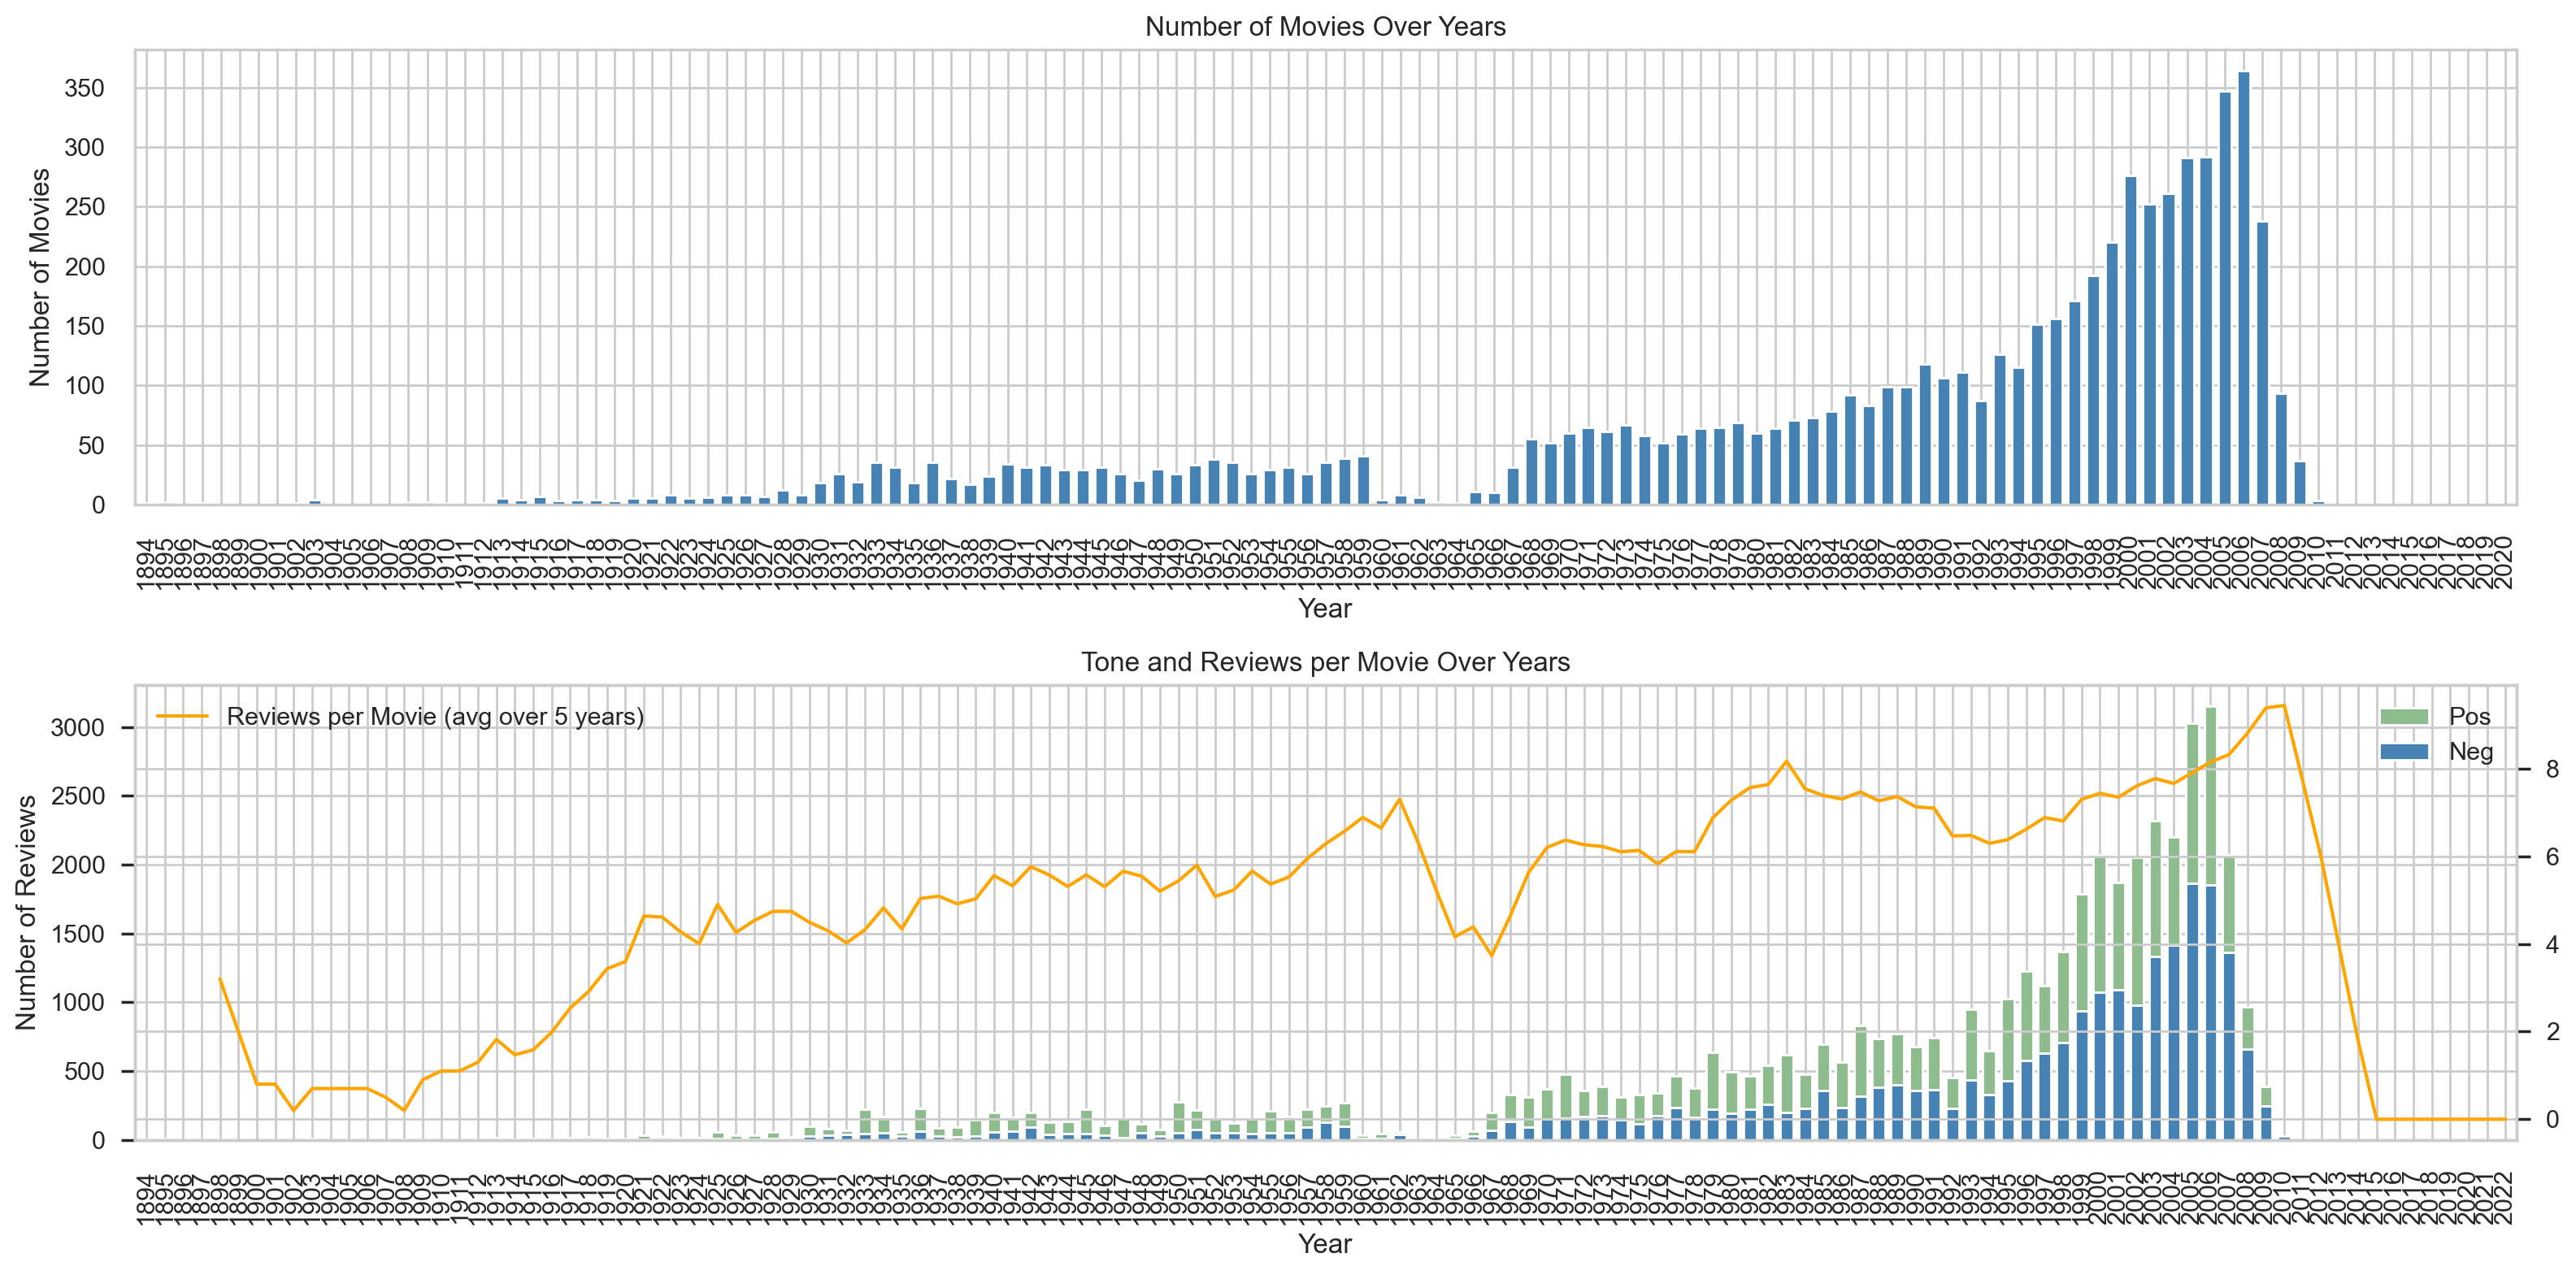

In [67]:
# Create supblots
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Number of movies by year
ax0 = axs[0]

movies_year = df_reviews.groupby('start_year')['tconst'].nunique()
movies_year = movies_year.reindex(index=np.arange(movies_year.index.min(), 
                                    max(movies_year.index.max(), 2021))).fillna(0)

movies_year.plot(kind='bar', color='steelblue', ax=ax0,
                 title='Number of Movies Over Years', xlabel='Year', 
                 ylabel='Number of Movies', width=0.7)

# Tone of review over time
ax1 = axs[1]

pos_year = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
pos_year = pos_year.reindex(index=np.arange(pos_year.index.min(), 
                                            max(pos_year.index.max(), 2023)), fill_value=0)

pos_year.plot(kind='bar', ax=ax1, stacked=True, color=['steelblue', 'darkseagreen'],
              legend='reverse', width=0.7)

plt.title('Tone and Reviews per Movie Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
ax1.add_artist(ax1.legend(['Neg', 'Pos'], reverse=True))

# Add rolling average reviews per movie over 5 years
axt = ax1.twinx() 

review_total = df_reviews.groupby('start_year')['tconst'].count()
review_total = review_total.reindex(index=np.arange(review_total.index.min(), 
                                                    max(review_total.index.max(), 2023))).fillna(0)
review_movie_year = (review_total / movies_year).fillna(0)

review_movie_year.reset_index(drop=True).rolling(5).mean() \
.plot(kind='line', ax=axt, color='orange', label='Reviews per Movie (avg over 5 years)')

lines, labels = axt.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left')

# Display figures
fig.tight_layout()
plt.show()

The number of movies per year generally increases over time until 2006, when we see a sharp decline in number of movies produced per year. There are generally similar numbers of positive and negative reviews per year. The number of reviews per movie tends to increase over time, from about 1 review per movie in the early 1900s to amost 10 reviews per movie in 2010.

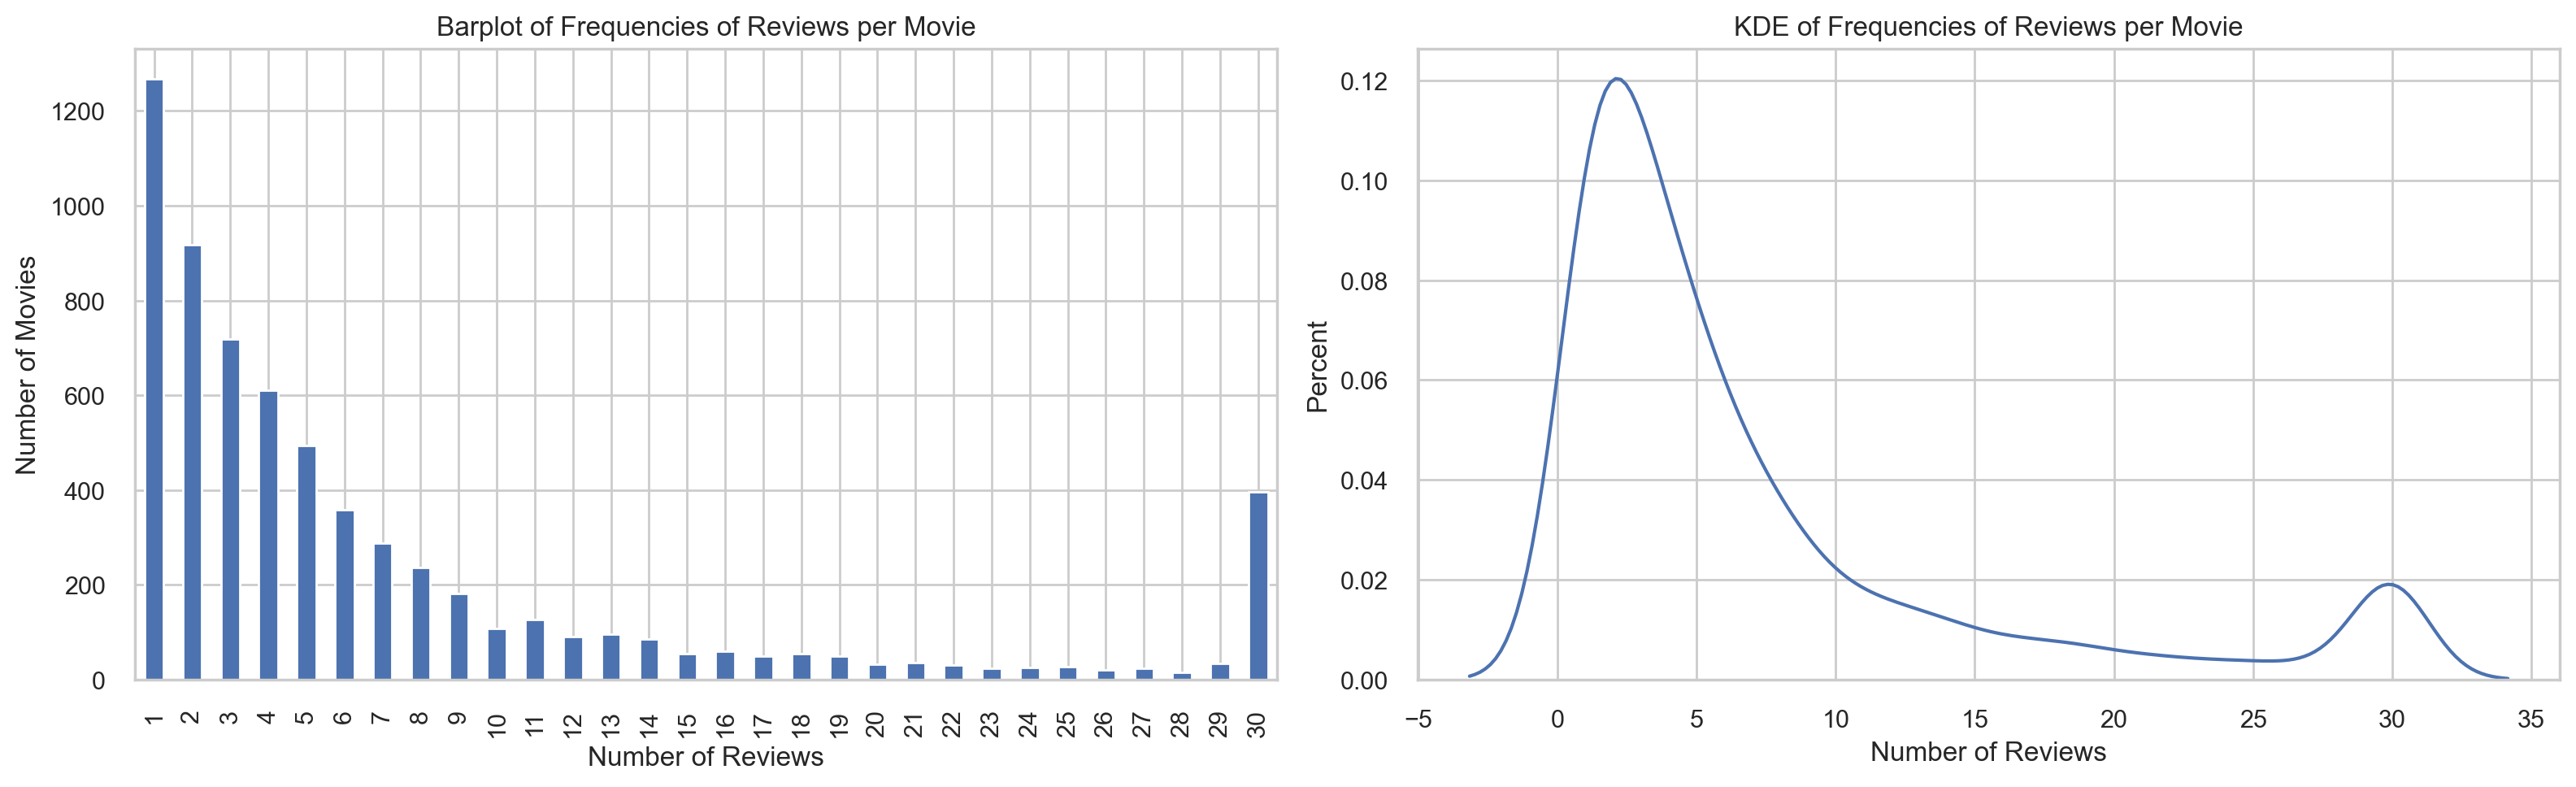

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

review_movie = df_reviews.groupby('tconst')['review'].count() \
    .value_counts().sort_index()

# Barplot of review per movie frequency
ax0 = axs[0]

review_movie.plot(kind='bar', ax=ax0, title='Barplot of Frequencies of Reviews per Movie',
                  xlabel='Number of Reviews', ylabel='Number of Movies')

# KDE of review per movie frequency
ax1 = axs[1]

review_movie = df_reviews.groupby('tconst')['review'].count()

sns.kdeplot(data=review_movie, ax=ax1)

ax1.set_title('KDE of Frequencies of Reviews per Movie')
ax1.set_xlabel('Number of Reviews')
ax1.set_ylabel('Percent')

# Display
fig.tight_layout()
plt.show()

Most movies tend to recieve betweeen 1 - 5 reviews per movie. The number of movies tends to decrease as the number of reviews increase, though there is a spike in a number of movies that have recieved 30 reviews.

### Examine train and test set

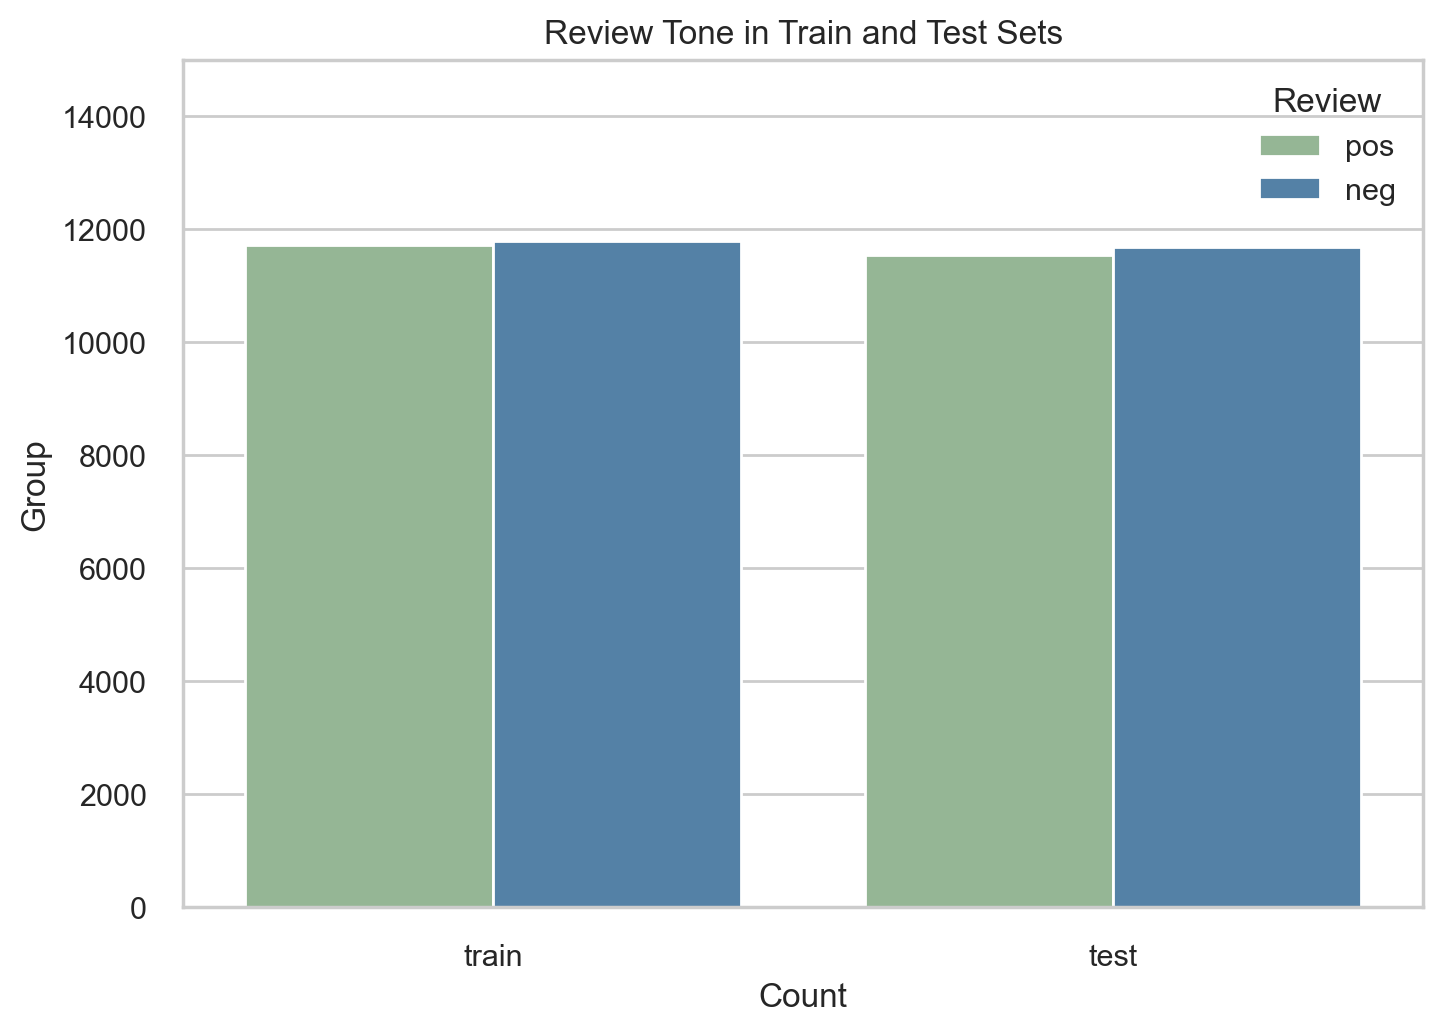

In [69]:
# Plot positive and negative review in train and test
ds_group_tone = sns.countplot(data=df_reviews, x='ds_part', hue='sp', hue_order=['pos', 'neg'],
              palette=('darkseagreen', 'steelblue'))

ds_group_tone.set(title='Review Tone in Train and Test Sets', xlabel='Count', ylabel='Group')

plt.legend(title='Review')
plt.ylim([0, 15000])

plt.show()

There are similar numbers of positive and negative reviews in the training and test sets. Additionally, there are similar numbers of positive reviews and similar numbers of negative reviews across the training and test sets. The classes are mostly balanced, and the trianing and test set are similar to each other.

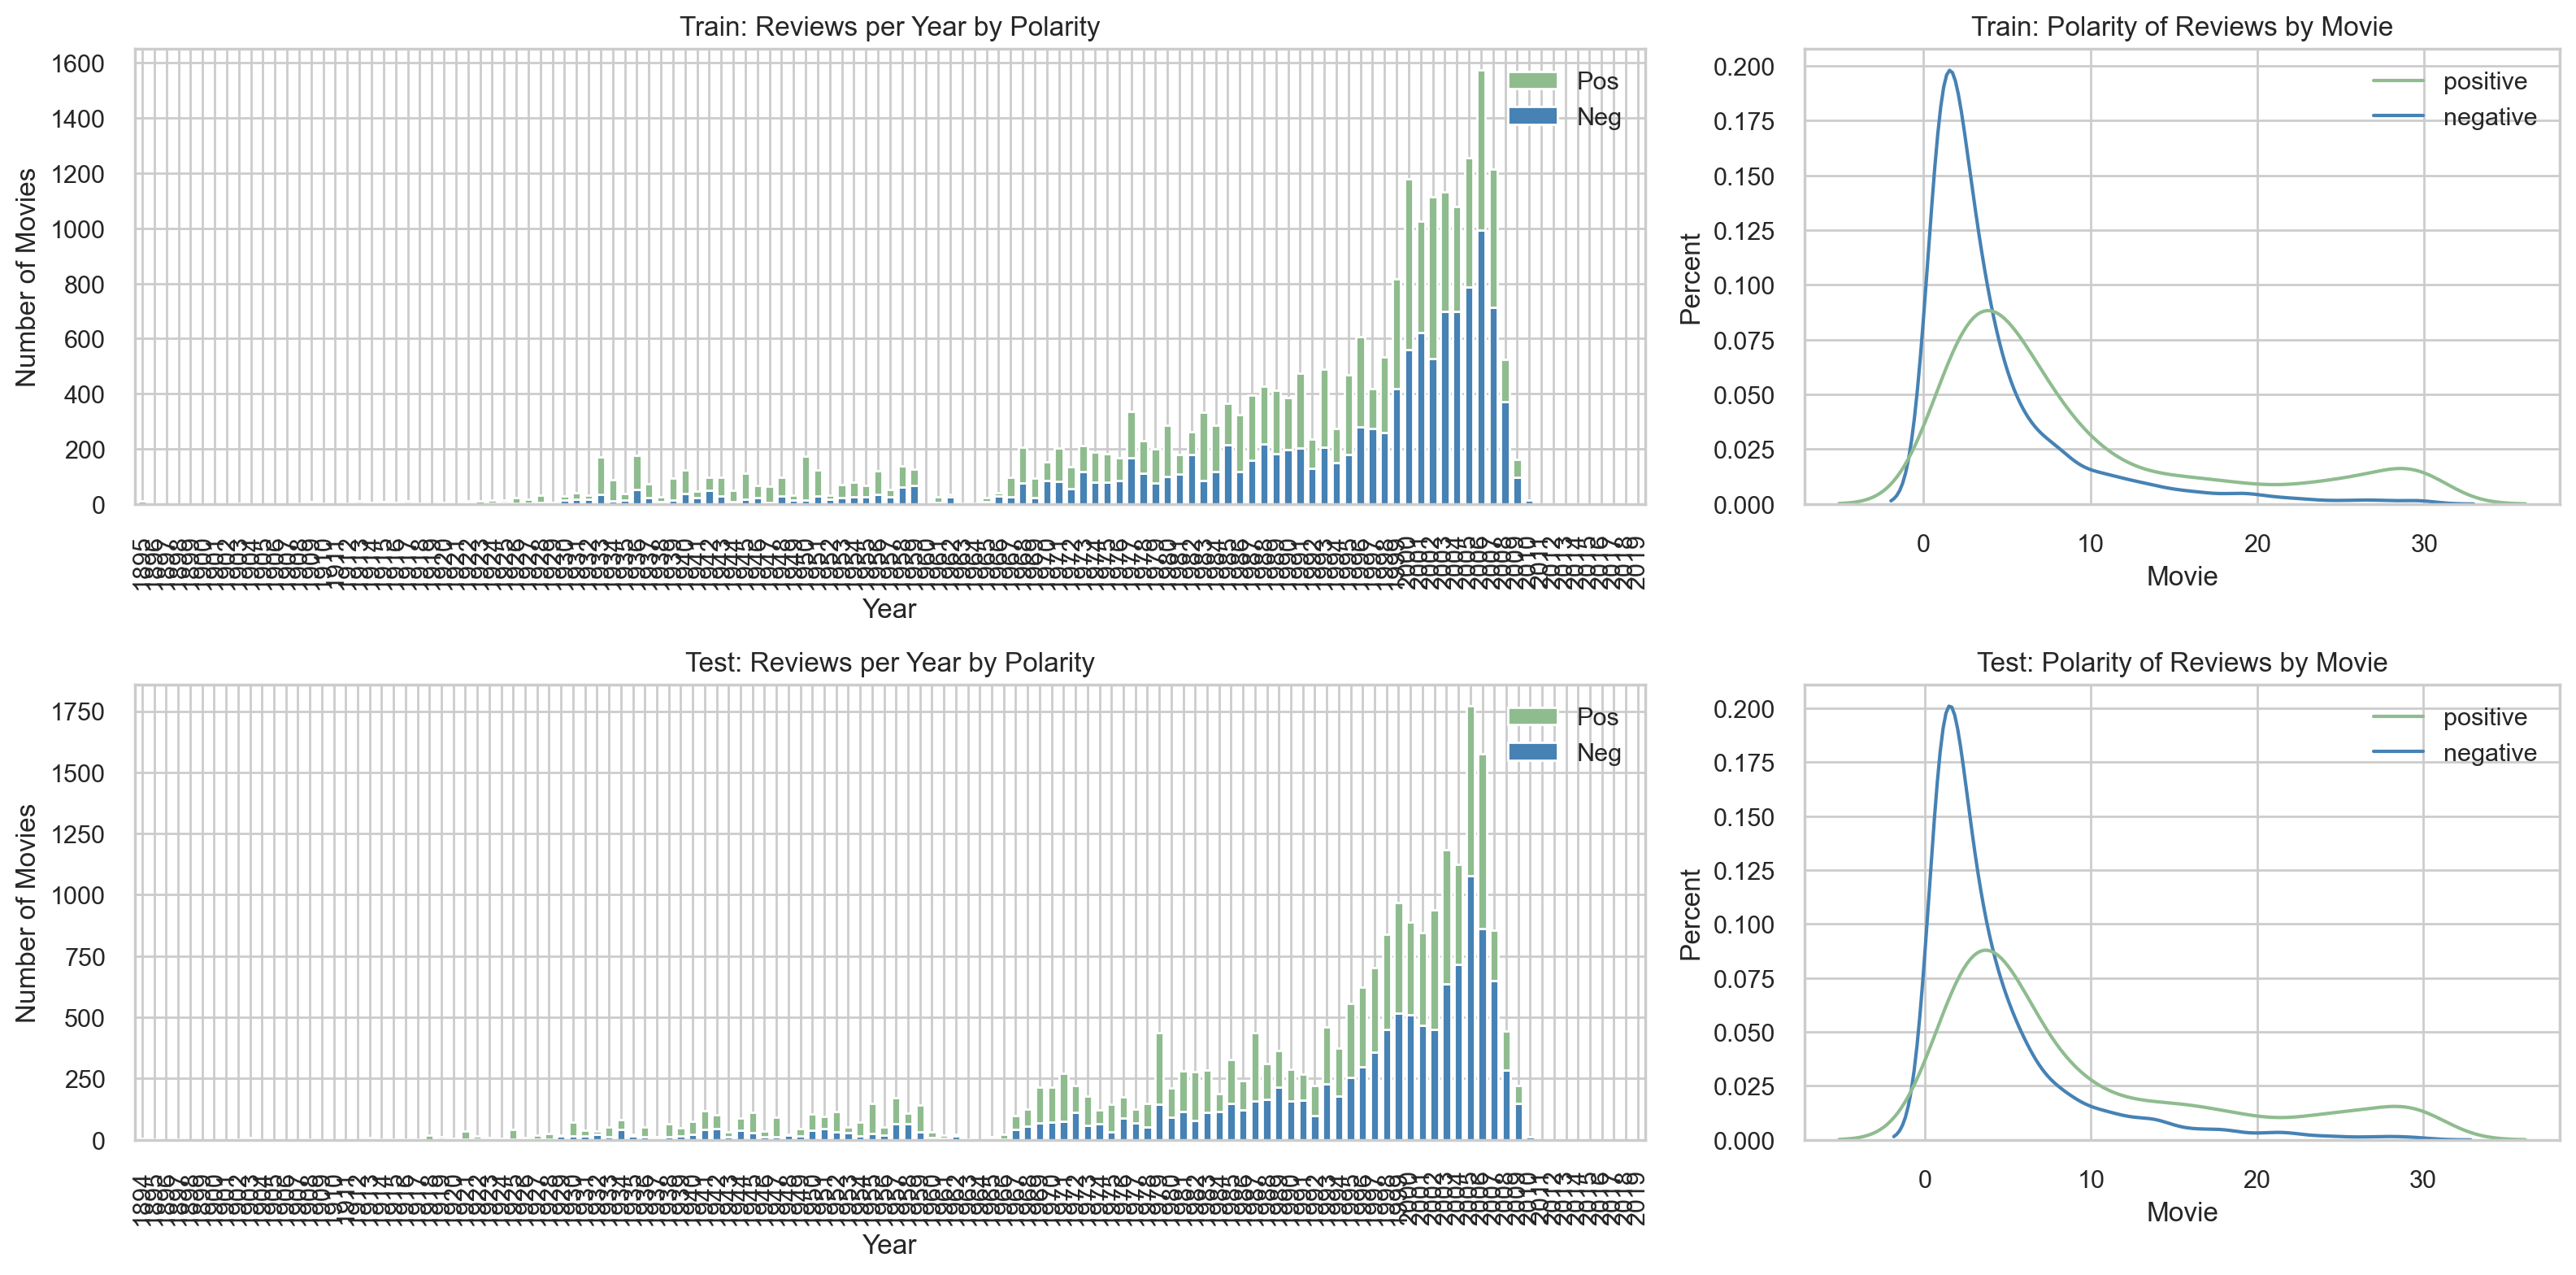

In [70]:
# Chart review tone by year for train/test
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Plot train movies over time
ax0 = axs[0][0]

df_train_year = df_reviews[df_reviews['ds_part'] == 'train'].groupby(['start_year', 'pos'])['pos'].count().unstack()
df_train_year = df_train_year.reindex(index=np.arange(df_train_year.index.min(), max(df_train_year.index.max(), 2020))).fillna(0)

df_train_year.plot(kind='bar', ax=ax0, stacked=True, color=['steelblue', 'darkseagreen'], width=0.7,
                   title='Train: Reviews per Year by Polarity', xlabel='Year', ylabel='Number of Movies')

ax0.legend(['Neg', 'Pos'], reverse=True)

# Train density plot review tone by movie
ax1 = axs[0][1]

tone_train = df_reviews[df_reviews['ds_part'] == 'train'].groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(tone_train[0], color='steelblue', label='negative', ax=ax1)
sns.kdeplot(tone_train[1], color='darkseagreen', label='positive', ax=ax1)

ax1.legend(reverse=True)

ax1.set_title('Train: Polarity of Reviews by Movie')
ax1.set_xlabel('Movie')
ax1.set_ylabel('Percent')

# Test movies over time
ax2 = axs[1][0]

df_test_year = df_reviews[df_reviews['ds_part'] == 'test'].groupby(['start_year', 'pos'])['pos'].count().unstack()
df_test_year = df_test_year.reindex(index=np.arange(df_test_year.index.min(), max(df_test_year.index.max(), 2020))).fillna(0)

df_test_year.plot(kind='bar', ax=ax2, stacked=True, color=['steelblue', 'darkseagreen'], width=0.7,
                   title='Test: Reviews per Year by Polarity', xlabel='Year', ylabel='Number of Movies')

ax2.legend(['Neg', 'Pos'], reverse=True)

# Test review tone by movie
ax3 = axs[1][1]

tone_test = df_reviews[df_reviews['ds_part'] == 'test'].groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(tone_test[0], color='steelblue', label='negative', ax=ax3)
sns.kdeplot(tone_test[1], color='darkseagreen', label='positive', ax=ax3)

ax3.legend(reverse=True)

ax3.set_title('Test: Polarity of Reviews by Movie')
ax3.set_xlabel('Movie')
ax3.set_ylabel('Percent')

# Display
fig.tight_layout()
plt.show()

There are similar distributions of movie reviews by year and by polarity in the training and test sets. The sets are similar and can be used to train and test the model.

### Exploratory analysis conclusion

## **Evaluation Procedure**

Create evaluation routine which can be used for all models in this project.

In [71]:
def evaluate_model(model, features_train, target_train, features_test, target_test):
    '''Displays the F1 score curve, ROC curve, and precision recall curve, and a
    data frame of ROC, APS, Accuracy, and F1 score for training and test sets.
    
    model: fitted classification model
    features_train: features of the training set
    target_train: target for the training set
    features_test: features of the test set
    target_test: target for the test set'''
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    
    for type, features, target in (('train', features_train, target_train), ('test', features_test, target_test)):
        
        eval_stats[type] = {}
        
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1 scores
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc
        
        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        # Plot threshold curves
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'
            
        # F1 score curve
        ax0 = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax0.plot(f1_thresholds, f1_scores, color=color, 
                label=f'{type}, max={f1_scores[max_f1_score_idx]:2f} @ {f1_thresholds[max_f1_score_idx]:2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax0.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], 
                    color=marker_color, marker='X', markersize=7)
        ax0.set_xlim([-0.02, 1.02])
        ax0.set_ylim([-0.02, 1.02])
        ax0.set_xlabel('Threshold')
        ax0.set_ylabel('F1')
        ax0.legend(loc='lower center')
        ax0.set_title('F1 Score')
            
        # ROC curve
        ax1 = axs[1]
        ax1.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax1.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, 
                    marker='X', markersize=7)
        ax1.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax1.set_xlim([-0.02, 1.02])
        ax1.set_ylim([-0.02, 1.02])
        ax1.set_xlabel('FPR')
        ax1.set_ylabel('TPR')
        ax1.legend(loc='lower center')
        ax1.set_title('ROC Curve')


        # PRC
        ax2 = axs[2]
        ax2.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax2.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, 
                    marker='X', markersize=7)
        ax2.set_xlim([-0.02, 1.02])    
        ax2.set_ylim([-0.02, 1.02])
        ax2.set_xlabel('recall')
        ax2.set_ylabel('precision')
        ax2.legend(loc='lower center')
        ax2.set_title(f'PRC') 
        
        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
        
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## **Normalization**

Remove special characters and numbers from text and convert to lowercase.

In [72]:
# Define function to normalize text
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    text = text.split()
    text = " ".join(text)
    
    return text

# Apply normalize function to review column
df_reviews['reviews_norm'] = df_reviews['review'].apply(normalize_text)

display(df_reviews[['review', 'reviews_norm']].head())

,review,reviews_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenting...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in sing...
4,I'm totally agree with GarryJohal from Singapo...,i'm totally agree with garryjohal from singapo...


Reviews are converted to lowercase with special characters removed.

## **Train/Validate/Test Split**

In [73]:
# Define train and test subsets
df_train = df_reviews[df_reviews['ds_part'] == 'train']
df_test = df_reviews[df_reviews['ds_part'] == 'test']

# Define train and test targets
targ_train = df_train['pos']
targ_test = df_test['pos']

print(f'Train Shape: {df_train.shape}')
print(f'Test Shape: {df_test.shape}')

Train Shape: (23504, 18)
Test Shape: (23232, 18)


Training and test set are split approximately 50/50 split. The test set has 270 fewer observations than the training set.

## **NLP Classification Models**

Train models to classify the tone of the review.

### Model 0 - Constant Model

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


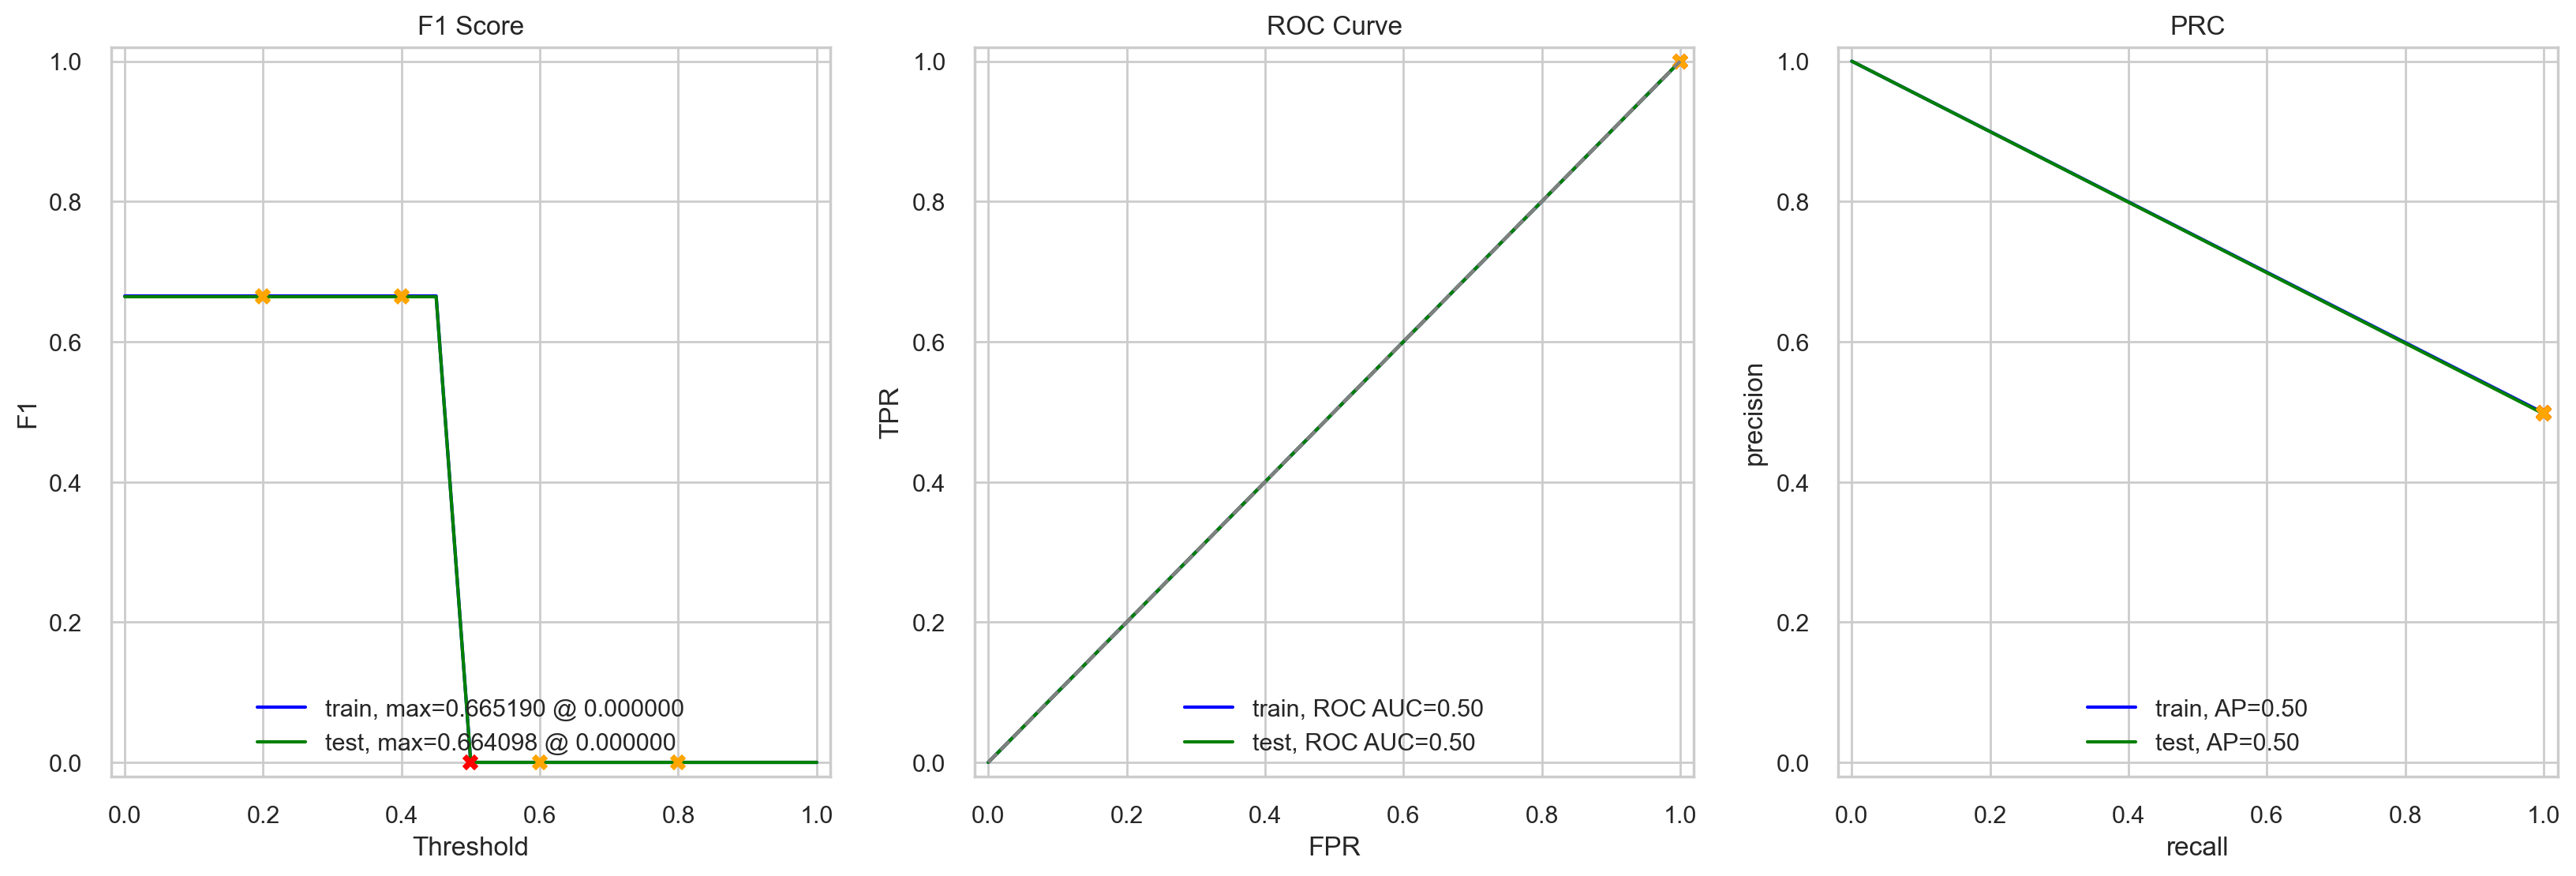

In [74]:
# Fit dummy model
dummy = DummyClassifier().fit(df_train['reviews_norm'], targ_train)

# Evalate train and test set
evaluate_model(dummy, df_train['reviews_norm'], targ_train, df_test['reviews_norm'], targ_test)

### Model 1 - NLTK, TF-IDF and Logistic Regression

In [75]:
# Lemmatize reviews with nltk lemmatizer
nltk_lemmatizer = WordNetLemmatizer()

def nltk_lemmatize(text):
    nltk_tokens = word_tokenize(text)
    nltk_lemmas = [nltk_lemmatizer.lemmatize(token) for token in nltk_tokens]
    nltk_lemmas = " ".join(nltk_lemmas)
    return nltk_lemmas

df_train['reviews_nltk_lemma'] = df_train['reviews_norm'].apply(nltk_lemmatize)
df_test['reviews_nltk_lemma'] = df_test['reviews_norm'].apply(nltk_lemmatize)

display(df_train.head())

/var/folders/q7/2k38l43j455fh7f8t9_wlj240000gn/T/ipykernel_14180/3435623368.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['reviews_nltk_lemma'] = df_train['reviews_norm'].apply(nltk_lemmatize)
/var/folders/q7/2k38l43j455fh7f8t9_wlj240000gn/T/ipykernel_14180/3435623368.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['reviews_nltk_lemma'] = df_test['reviews_norm'].apply(nltk_lemmatize)


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,reviews_norm,reviews_nltk_lemma
0,tt0068152,movie,$,$,1971,NaN,121.0,0,"Comedy,Crime,Drama",6.3,2218.0,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...,the pakage implies that warren beatty and gold...
1,tt0068152,movie,$,$,1971,NaN,121.0,0,"Comedy,Crime,Drama",6.3,2218.0,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenting...,how the hell did they get this made presenting...
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,NaN,88.0,0,"Drama,History,War",6.1,1240.0,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903,this true story of carlson's raiders is more o...,this true story of carlson 's raider is more o...
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,NaN,88.0,0,"Drama,History,War",6.1,1240.0,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905,should have been titled 'balderdash ' little i...,should have been titled 'balderdash ' little i...
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,NaN,88.0,0,"Drama,History,War",6.1,1240.0,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904,the movie 'gung ho ' the story of carlson's ma...,the movie 'gung ho ' the story of carlson 's m...


Reviews are lemmatized via the nltk lemmatizer.

In [76]:
# Initiate pre-processor
stop_words = nltk_stopwords.words('english')

# Create TF-IDF features for text, OHE categorical, and scale numeric
column_trans_nltk = ColumnTransformer(
    [('text_nltk', TfidfVectorizer(stop_words=stop_words), 'reviews_nltk_lemma'),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), ['title_type']),
    ('numeric', StandardScaler(), ['start_year', 'runtime_minutes']),
    ('pass', 'passthrough', ['is_adult'])],
    remainder='drop'
)

# Fit and transform train, transform validate
df_train_nltk = column_trans_nltk.fit_transform(df_train)
df_test_nltk = column_trans_nltk.transform(df_test)

print(f'NLTK Train DF Shape: {df_train_nltk.shape}')
print(f'NLTK Validate DF Shape: {df_test_nltk.shape}')

NLTK Train DF Shape: (23504, 63902)
NLTK Validate DF Shape: (23232, 63902)


Train and validate set features have been fit and transformed. Text is broken into TF-IDF matrix, categorical features are OHE, and numeric features are min max scaled.

In [77]:
# Define features and target
feat_train_nltk = df_train_nltk
feat_test_nltk = df_test_nltk

targ_train_nltk = df_train['pos']
targ_test_nltk = df_test['pos']

In [78]:
# Run logistic regression
log_reg = LogisticRegression(max_iter=300)

log_reg.fit(feat_train_nltk, targ_train_nltk)

LogisticRegression(max_iter=300)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


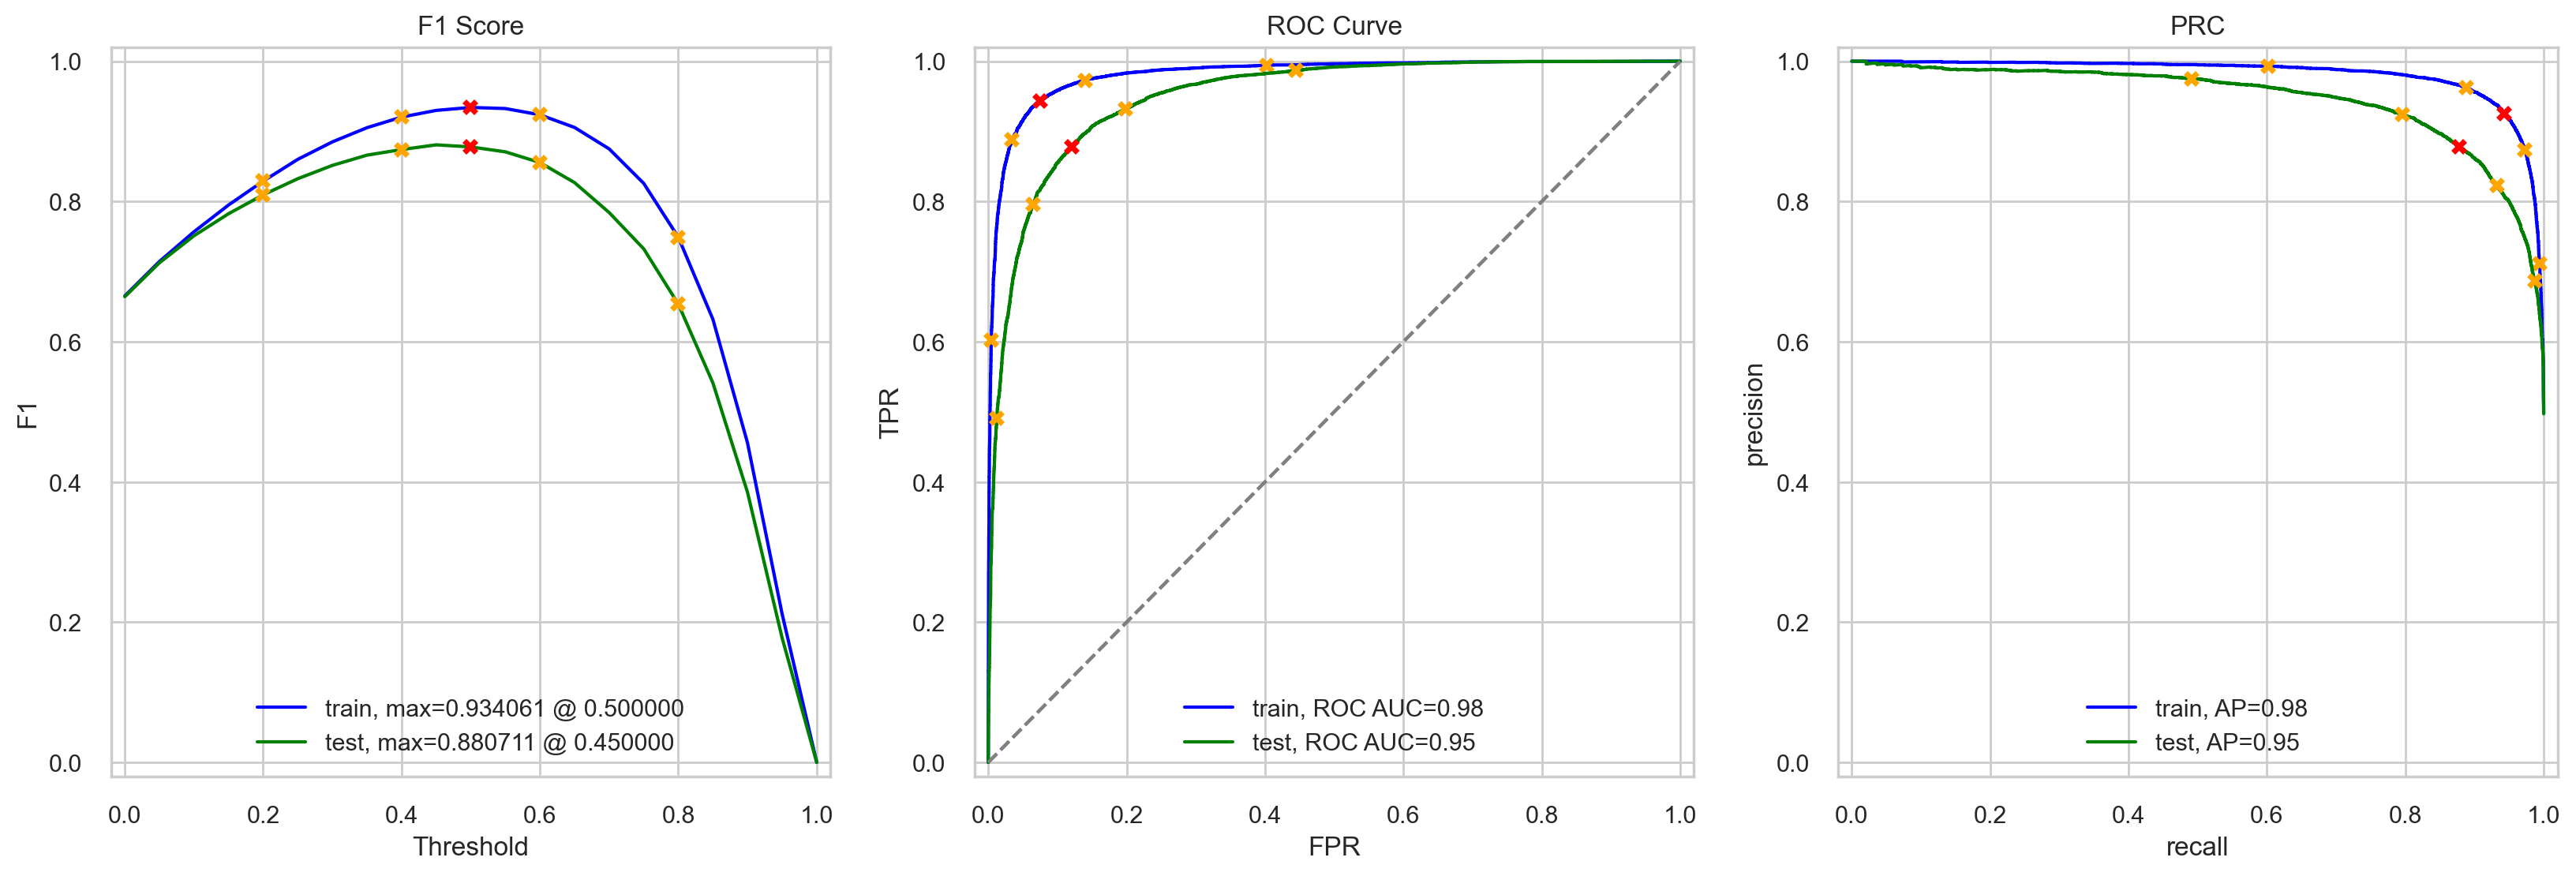

In [79]:
# Evaluate logistic regression
evaluate_model(log_reg, feat_train_nltk, targ_train_nltk, df_test_nltk, targ_test_nltk)

Logistic regression with text vectorized with NLTK TF-IDF was able to achieve a maximum F1 score of 0.88 at a threshold of 0.45 on the test set. It had a validation ROC AUC of 0.95 and a validation PRC of 0.95. This model is good at classifying reviews based on media type, year, runtime, and review text.

### Model 2 - spaCy, TF-IDF, and Logistic Regression

In [80]:
# Lemmatize reviews with spaCy lemmatizer
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def spacy_lemmatize(text):
    tokens = nlp(text)
    spacy_lemmas = [token.lemma_ for token in tokens]
    spacy_lemmas = " ".join(spacy_lemmas)
    
    return spacy_lemmas

df_train['reviews_spacy_lemmas'] = df_train['reviews_norm'].apply(spacy_lemmatize)
df_test['reviews_spacy_lemmas'] = df_test['reviews_norm'].apply(spacy_lemmatize)

display(df_train.head())

/var/folders/q7/2k38l43j455fh7f8t9_wlj240000gn/T/ipykernel_14180/189001472.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['reviews_spacy_lemmas'] = df_train['reviews_norm'].apply(spacy_lemmatize)
/var/folders/q7/2k38l43j455fh7f8t9_wlj240000gn/T/ipykernel_14180/189001472.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['reviews_spacy_lemmas'] = df_test['reviews_norm'].apply(spacy_lemmatize)


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,reviews_norm,reviews_nltk_lemma,reviews_spacy_lemmas
0,tt0068152,movie,$,$,1971,NaN,121.0,0,"Comedy,Crime,Drama",6.3,2218.0,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...,the pakage implies that warren beatty and gold...,the pakage imply that warren beatty and goldie...
1,tt0068152,movie,$,$,1971,NaN,121.0,0,"Comedy,Crime,Drama",6.3,2218.0,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenting...,how the hell did they get this made presenting...,how the hell do they get this make present its...
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,NaN,88.0,0,"Drama,History,War",6.1,1240.0,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903,this true story of carlson's raiders is more o...,this true story of carlson 's raider is more o...,this true story of carlson 's raider be more o...
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,NaN,88.0,0,"Drama,History,War",6.1,1240.0,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905,should have been titled 'balderdash ' little i...,should have been titled 'balderdash ' little i...,should have be title ' balderdash ' little in ...
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,NaN,88.0,0,"Drama,History,War",6.1,1240.0,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904,the movie 'gung ho ' the story of carlson's ma...,the movie 'gung ho ' the story of carlson 's m...,the movie ' gung ho ' the story of carlson 's ...


Review text has been lemmatized with spaCy.

In [81]:
# Transform reviews to tf-idf vectors
stop_words = list(nlp.Defaults.stop_words)

column_trans_spacy = ColumnTransformer(
    [('text_spacy', TfidfVectorizer(stop_words = stop_words), 'reviews_spacy_lemmas'),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), ['title_type']),
    ('numeric', StandardScaler(), ['start_year', 'runtime_minutes']),
    ('pass', 'passthrough', ['is_adult'])],
    remainder='drop'
)

# Fit and transform train, transform validate
df_train_spacy = column_trans_spacy.fit_transform(df_train)
df_test_spacy = column_trans_spacy.transform(df_test)

print(f'NLTK Train DF Shape: {df_train_spacy.shape}')
print(f'NLTK Validate DF Shape: {df_test_spacy.shape}')

/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


NLTK Train DF Shape: (23504, 58556)
NLTK Validate DF Shape: (23232, 58556)


The training and validated set have 50220 columns representing TF-IDF text values and title, start year, runtime, and adult columns.

In [82]:
# Define features and target
feat_train_spacy = df_train_spacy
feat_test_spacy = df_test_spacy

targ_train = df_train['pos']
targ_valid = df_test['pos']

In [83]:
# Run logistic regression
log_reg_spacy = LogisticRegression(max_iter=300)

log_reg_spacy.fit(feat_train_spacy, targ_train)

LogisticRegression(max_iter=300)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


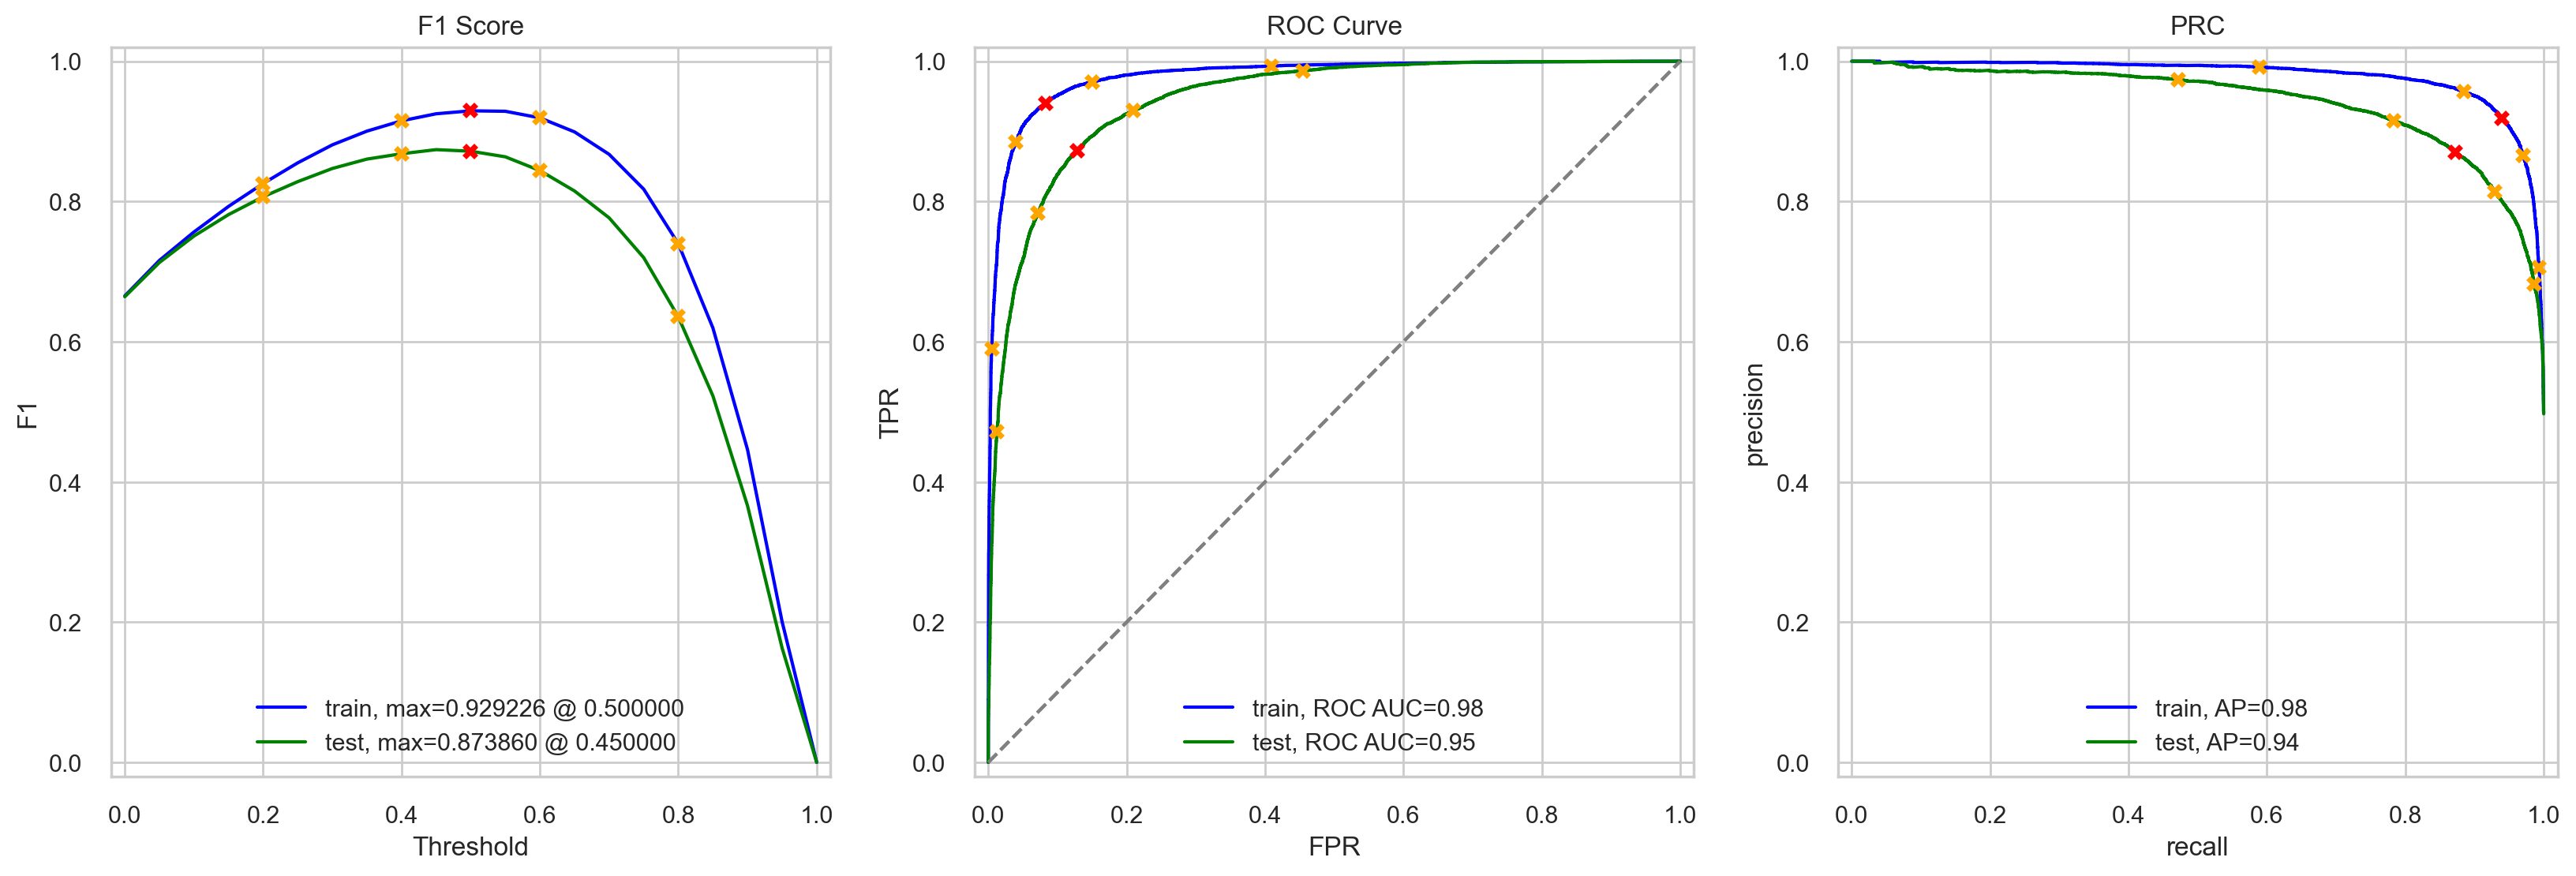

In [84]:
# Evaluate logistic regression with spaCy TF-IDF
evaluate_model(log_reg_spacy, feat_train_spacy, targ_train, 
               feat_test_spacy, targ_test)

The NLP model with spaCy lemmatization and TF-IDF vectorization achieved a maximum F1 score of 0.88 on the validation set with at a threshold of 0.50. This is slightly lower than the model fit with NLTK lemmatization. This model also achieved a ROC AUC of 0.95 and a PRC of 0.95 on the validation set. This is another well fitting model for the data, though no better than the NLTK version.

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [90]:
print(feat_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 23504 entries, 0 to 47257
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   tconst                23504 non-null  category
 1   title_type            23504 non-null  category
 2   primary_title         23504 non-null  category
 3   original_title        23504 non-null  category
 4   start_year            23504 non-null  int64   
 5   end_year              1016 non-null   category
 6   runtime_minutes       23504 non-null  float64 
 7   is_adult              23504 non-null  int64   
 8   genres                23504 non-null  category
 9   average_rating        23504 non-null  float64 
 10  votes                 23504 non-null  float64 
 11  review                23504 non-null  category
 12  rating                23504 non-null  int64   
 13  sp                    23504 non-null  category
 14  ds_part               23504 non-null  category
 15  idx    

In [93]:
# Define features and target
feat_train = df_train.drop('pos', axis=1)
targ_train = df_train['pos']

# Change object data types to category
for col in feat_train.columns:
    if feat_train[col].dtypes == object:
        feat_train[col] = feat_train[col].astype('category')

# Preprocessor
column_trans_lgbm = ColumnTransformer(
    [('text_spacy', TfidfVectorizer(stop_words = stop_words), 'reviews_spacy_lemmas'),
    ('numeric', StandardScaler(), ['start_year', 'runtime_minutes']),
    ('pass', 'passthrough', ['is_adult'])],
    remainder='drop'
)

# Initiate model, pipeline, and grid
lightgbm = LGBMClassifier(random_state=123, n_estimators=150, verbose=-1)

pipeline = Pipeline([('preprocessor', column_trans_lgbm), ('gbm', lightgbm)])

grid = {
    'gbm__num_leaves':[10, 50, 100],
    'gbm__max_depth': [7, 10, 15, 20],
    'gbm__learning_rate':[.1, .3, .5, 1]
}

# GridSearchCV
lightgbm_gscv = GridSearchCV(pipeline, param_grid=grid, scoring='f1', cv=3)
lightgbm_gscv.fit(feat_train, targ_train)

/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words genera

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('text_spacy',
                                                                         TfidfVectorizer(stop_words=['three',
                                                                                                     'off',
                                                                                                     'on',
                                                                                                     'however',
                                                                                                     'here',
                                                                                                     'toward',
                                                                                                     'am',
                                                                                                     'yourselves',
                                                                                                     'thereupon',
                                                                                                     'n‘t',
                                                                                                     'everywhere',
                                                                                                     'sixty',
                                                                                                     'third',
                                                                                                     'throughout',
                                                                                                     'often',
                                                                                                     'whatever',
                                                                                                     'down',
                                                                                                     'can',
                                                                                                     'perhaps',
                                                                                                     'themselves',
                                                                                                     'go',
                                                                                                     'such',
                                                                                                     'whereby',
                                                                                                     'not',
                                                                                                     'seems',
                                                                                                     'h...
                                                                                                     'where',
                                                                                                     'somehow',
                                                                                                     'full', ...]),
                                                                         'reviews_spacy_lemmas'),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         ['start_year',
                                                                          'runtime_minutes']),
                                                                        ('pass',
                                                                         'passthrough',
    

Student comment - How do I supress or fix these stop words warnings?

In [94]:
# Print best parameters
print(lightgbm_gscv.best_params_)

{'gbm__learning_rate': 0.3, 'gbm__max_depth': 10, 'gbm__num_leaves': 10}


/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


          train  test
Accuracy   0.97  0.86
F1         0.97  0.86
APS        1.00  0.94
ROC AUC    1.00  0.94


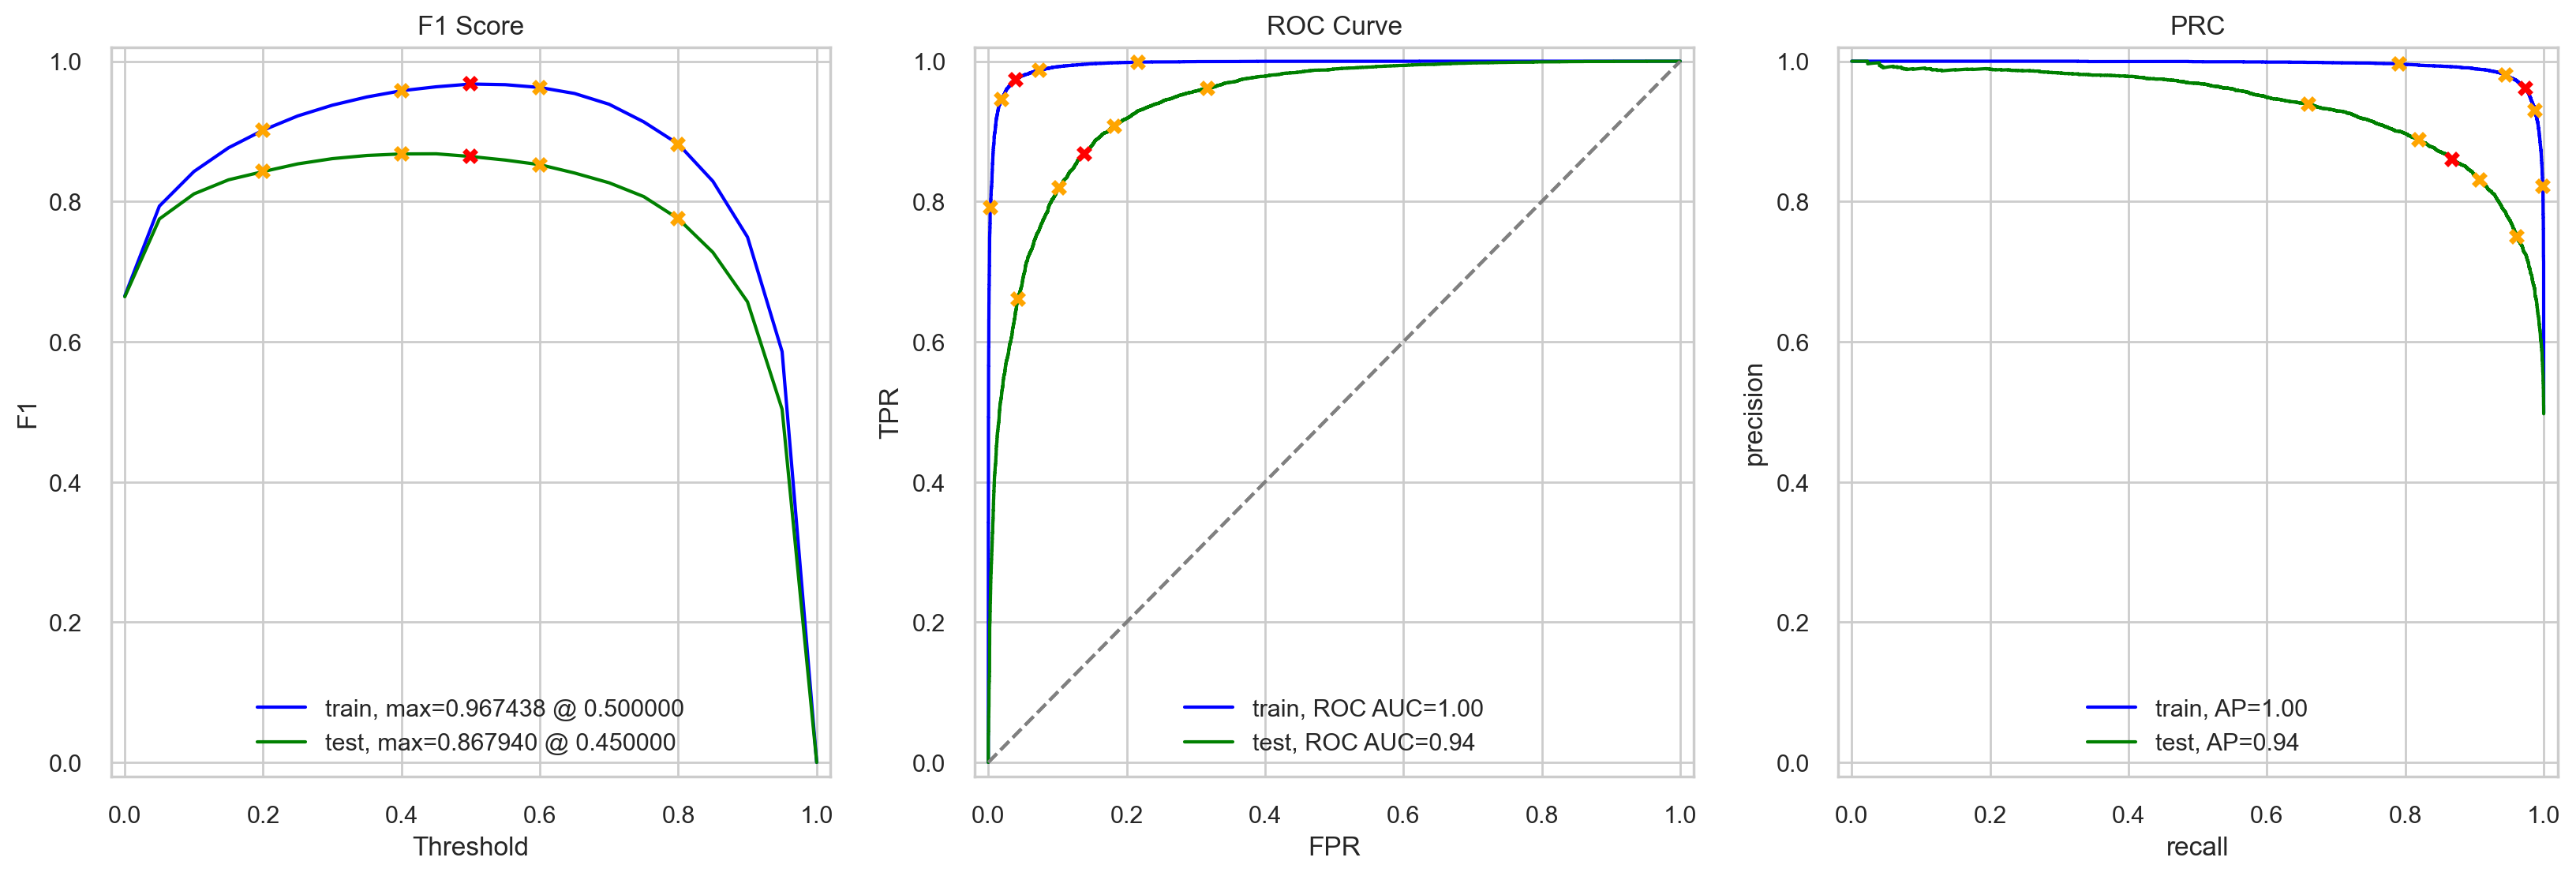

In [96]:
# Evaluate best model
lgbm_best = LGBMClassifier(num_leaves=10,
                           max_depth=10,
                           learning_rate=0.3,
                           n_estimators=300,
                           random_state=123,
                           verbose=-1)

pipeline_lgbm_best = Pipeline([('preprocessor', column_trans_lgbm), ('gbm', lgbm_best)])

pipeline_lgbm_best.fit(df_train, targ_train)

evaluate_model(pipeline_lgbm_best, df_train, targ_train, df_test, targ_test)

### Model 4 - BERT

In [101]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100,
                            force_device=None, disable_progress_bar=False)   
    # Preprocessing
    ids_list = []
    attention_mask_list = []

    for input_text in texts:
        ids = tokenizer.encode(
            input_text.lower(),
            add_special_tokens=True,
            truncation=True,
            max_lenght=max_length
        )
        padded = np.array_split(ids + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
        
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # Getting Embeddings in batches
    embeddings = []
    
    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), 
                  disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)